DỰ BÁO SỐ CA MẮC MỚI VÀ TỬ VONG MỚI BẰNG MÔ HÌNH ARIMA


In [1]:
import pandas as pd
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
import datetime
from datetime import date
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def download_data():
    # Get data updated
    if os.path.exists('data.csv'):
        os.remove('data.csv')

    # url = link
    try:
        file = wget.download(url, out='data.csv')
        print("\n")
    except:
        print("BAD", url)

def load_series(filename):
    # Load series to predict
    series = pd.read_csv(filename)
    new_positives = series['case_by_day'].values
    new_deaths = series['death_by_day'].values
    dates = series['date'].values
    return new_positives[:-18], new_deaths[:-18], dates[:-18]


Chuẩn hóa chuỗi dữ liệu

In [4]:
# Dowload and loading series
# download_data()
filename = 'data/HCM.csv'
new_positives, new_deaths, dates = load_series(filename)

def standardize_array(data):
    data = [x + 1 for x in data]
    r_t = np.log(data/ np.roll(data, 1))
    mean = np.nanmean(r_t)
    #mean = np.nanmean(r_t)

    r_t[0]= mean
    return r_t[-25:]

r_t = standardize_array(new_positives)
r_t2 = standardize_array(new_deaths)

# New section

In [ ]:
#LA
#def load_series(filename):
    # Load series to predict
#    series = pd.read_csv(filename)
#    new_positives = series['case_by_day'].values
#    new_deaths = series['death_by_day'].values
#    dates = series['date'].values
#    return new_positives, new_deaths, dates
#filename = 'data/HCM.csv'
#new_positives, new_deaths, dates = load_series(filename)
#pos_q = new_positives.mean()
#pos_q


In [ ]:
print(r_t)

Lựa chọn q

<Figure size 576x432 with 0 Axes>

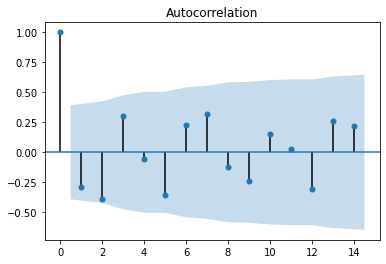

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax1 = plot_acf(r_t)

Chọn q = 1

Lựa chọn p


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


<Figure size 576x432 with 0 Axes>

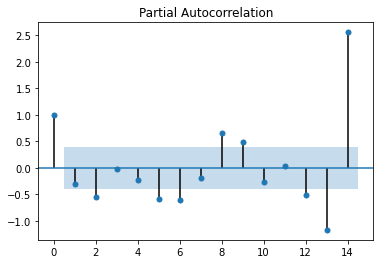

In [6]:
plt.figure(figsize = (8, 6))
ax2 = plot_pacf(r_t)

Chọn p = 1

Tới đây đã lựa chọn được tham số p, d, q cho mô hình

<Figure size 576x432 with 0 Axes>

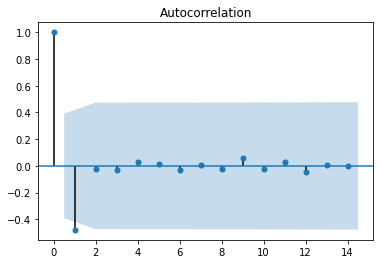

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax1 = plot_acf(r_t2)

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


<Figure size 576x432 with 0 Axes>

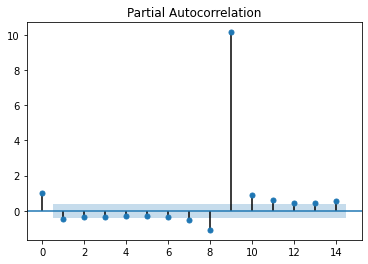

In [8]:
plt.figure(figsize = (8, 6))
ax2 = plot_pacf(r_t2)

In [9]:
# Default Order for ARIMA model
order = {
    'new_positives': (2, 0, 5),
    'new_deaths': (7, 0, 1),
}

In [15]:
def ARIMA_model(series, order, days = 7):
    # Fitting and forecast the series
    train = [x for x in series]
    model = ARIMA(train, order = order)
    model_fit = model.fit(disp=0)
    forecast, err, ci = model_fit.forecast(steps = days, alpha = 0.05)
    start_day = date.today() + datetime.timedelta(days = 1)
    predictions_df = pd.DataFrame({'Forecast':forecast.round()}, index=pd.date_range(start = date(2022, 1, 1), periods=days, freq='D'))
    return predictions_df, ci



In [16]:
def plot_results(series, df_forecast, ci, label):
    start_covid_day = date(2021, 8, 1)
    series = pd.DataFrame({'Real data':series}, index=pd.date_range(start = start_covid_day, periods=series.shape[0], freq='D'))
    ax = series.plot(label = 'Real Data', figsize = (20, 15))
    df_forecast.plot(ax = ax, label='Dự báo ', color = 'r')
    ax.fill_between(df_forecast.index,
                    ci[:,0],
                    ci[:,1], color='b', alpha=.25)
    ax.set_xlabel('Days')
    ax.set_ylabel(label)
    ax.set_title('Dự báo ' + label)
    plt.legend()
    plt.savefig('plots/' + label + '.png')
    #plt.show()
    print(df_forecast)



            Forecast
2022-01-01     666.0
2022-01-02     683.0
2022-01-03     707.0
2022-01-04     705.0
2022-01-05     735.0
2022-01-06     755.0
2022-01-07     777.0


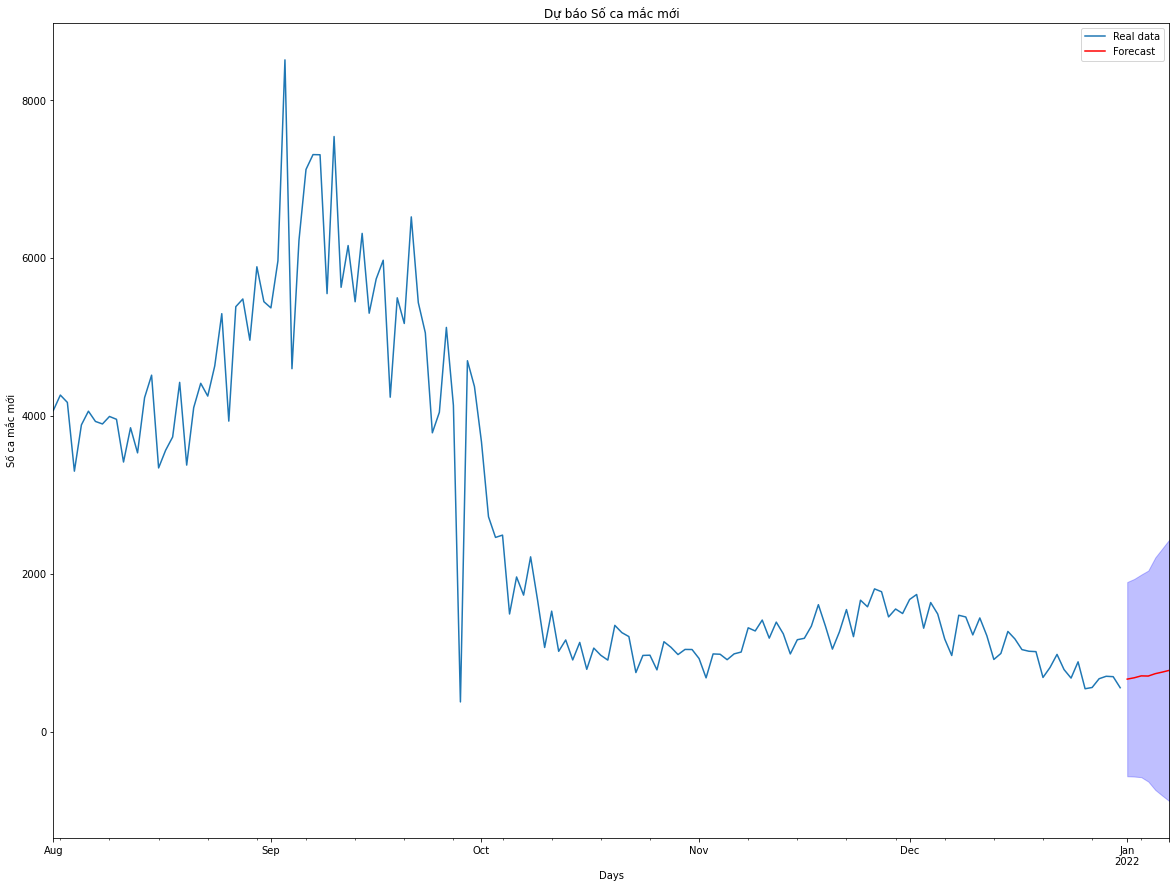

In [17]:
# Stats of today
new_positives_today, new_deaths_today, dates_today = new_positives[-1], new_deaths[-1], dates[-1]

# Forecasting with ARIMA models
new_positives_pred, new_positives_ci = ARIMA_model(new_positives, order['new_positives'])


# Plot Results
plot_results(new_positives, new_positives_pred, new_positives_ci, 'Số ca mắc mới')


            Forecast
2022-01-01      35.0
2022-01-02      30.0
2022-01-03      33.0
2022-01-04      35.0
2022-01-05      33.0
2022-01-06      33.0
2022-01-07      35.0


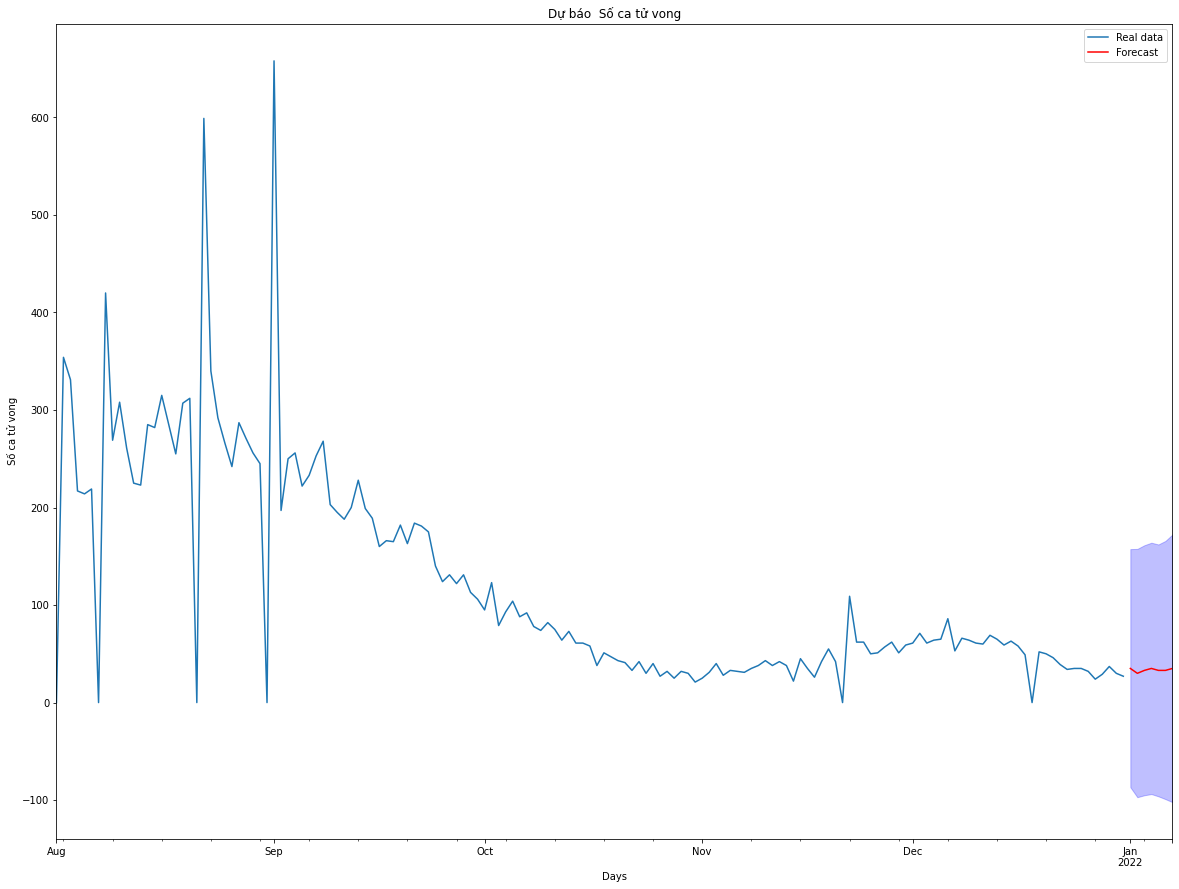

In [18]:
new_deaths_pred, new_deaths_ci = ARIMA_model(new_deaths, order['new_deaths'])

plot_results(new_deaths, new_deaths_pred, new_deaths_ci, ' Số ca tử vong')